In [313]:
# import dependencies
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, MetaData


# PyMySQL 
import pymysql
pymysql.install_as_MySQLdb()

In [314]:
# create engine for the hawaii database
engine = create_engine("sqlite:///hawaii.sqlite",  echo=False)

In [315]:
#engine.execute("SELECT * FROM measurements LIMIT 20").fetchall()

In [316]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [317]:
Station = Base.classes.stations
Measurement = Base.classes.measurements

In [318]:
session = Session(engine)

In [319]:
# Begin precipitation analysis. Query 12 months worth of precipitation data from the final measurement date

In [320]:
# find the last date of recorded measurments in the database in order to find the last 12 months worth of data
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [321]:
# create query for precipitation for the last 12 months of available records
weather = [Measurement.date, Measurement.prcp]
prcp_data = session.query(*weather).filter(Measurement.date > '2016-08-23').order_by(Measurement.date).all()

In [323]:
# store the precipitation data into a pandas dataframe
prcp_df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])

In [324]:
prcp_df['Date'] = prcp_df['Date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [325]:
prcp_df.set_index("Date", inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


In [326]:
prcp_df.tail()

,Precipitation
Date,
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45


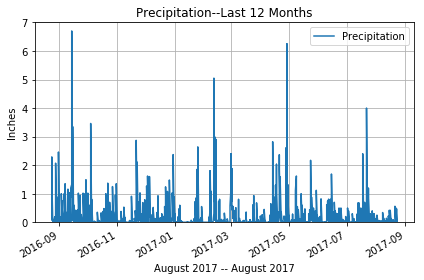

In [327]:
prcp_df.plot(x=prcp_df.index, y="Precipitation", kind='line', use_index=True, grid=True)
plt.ylim(0,7)
plt.ylabel("Inches")
plt.xlabel("August 2017 -- August 2017")
plt.title('Precipitation--Last 12 Months')
plt.tight_layout()
plt.savefig('precipitation.png')
plt.show()

In [328]:
# print the summary statistics for the precipitation data
print(prcp_df.describe())

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


In [329]:
## begin station analysis ##

In [330]:
# Design a query to calculate the total number of stations.
station_count = session.query(Station.station).count()
print(f'There are {station_count} total stations.')

There are 9 total stations.


In [331]:
# Design a query to find the most active stations.
active = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
active_loc = session.query(Station.name).filter(Station.station == np.ravel(active[0])[0]).all()
print(f'The most active station is {np.ravel(active[0])[0]}, {np.ravel(active_loc)[0]} , with {np.ravel(active[0])[1]} observations.')

The most active station is USC00519281, WAIHEE 837.5, HI US , with 2772 observations.


In [332]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
temp_data = [Measurement.station, Measurement.date, Measurement.tobs]
temp_obs = session.query(*temp_data).filter(Measurement.date > '2016-08-23').order_by(Measurement.date).all()

In [333]:
# Filter by the station with the highest number of observations.
session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
    filter(Measurement.date > '2016-08-23').order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519397', 358),
 ('USC00519281', 351),
 ('USC00513117', 342),
 ('USC00516128', 327),
 ('USC00519523', 313),
 ('USC00514830', 264),
 ('USC00517948', 60)]

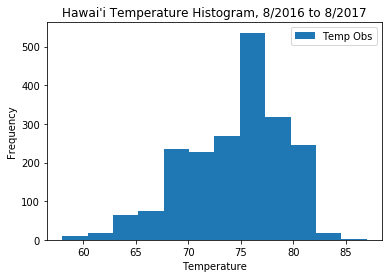

In [334]:
# Plot the results as a histogram with bins=12.
temp_df = pd.DataFrame(temp_obs, columns=['station', 'date', 'temp'])
plt.hist(temp_df["temp"], bins=12)
plt.title("Hawai'i Temperature Histogram, 8/2016 to 8/2017")
plt.ylabel("Frequency")
plt.xlabel('Temperature')
plt.legend(['Temp Obs'])
plt.savefig('Hawaii_temp_histogram.png')
plt.show()

In [341]:
## Begin temperature analysis ##
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the 
#minimum, average, and maximum temperatures for that range of dates.

def calc_temps():
    """returns a list featuring (min temp), (max temp) and (average temp) for the date range entered"""    
    start = input('Enter Search Start Date in YYYY-MM-DD format.')
    start_date = dt.datetime.strptime(start, '%Y-%m-%d').date()
    end = input('Enter Search End Date in YYYY-MM-DD format.')
    end_date = dt.datetime.strptime(end, '%Y-%m-%d').date()
    data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > start_date).filter(Measurement.date < end_date).all()
    df = pd.DataFrame(data, columns=['date', 'temp'])
    temp_min = df['temp'].min()
    temp_max = df['temp'].max()
    temp_av = df['temp'].mean()
    print(f'The average temperature was {round(temp_av, 2)}, with a high of {temp_max} and a low of {temp_min} F.')
    return [temp_min, temp_max, temp_av]

In [342]:
# Trip will be between July 15, 2018 & July 31, 2018, so we'll enter 2017-07-15 as start and 2017-07-31 as end search date.
trip = calc_temps()

Enter Search Start Date in YYYY-MM-DD format.2017-07-15
Enter Search End Date in YYYY-MM-DD format.2017-07-31
The average temperature was 78.7, with a high of 84 and a low of 72 F.


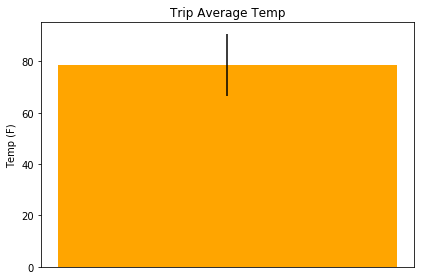

In [343]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
plt.bar(0, trip[2], yerr=(trip[1] - trip[0]), color='orange')
plt.title("Trip Average Temp")
plt.xticks([])
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.savefig('trip_avg_temp.png')
plt.show()

In [344]:
## Optional Recommended Analysis ##

In [345]:
# Calculate the rainfall per weather station using the previous year's matching dates.

def calc_rain():
    """returns a list featuring (min rain), (max rain) and (average rain) for the date-range entered"""    
    start = input('Enter Search Start Date in YYYY-MM-DD format.')
    start_date = dt.datetime.strptime(start, '%Y-%m-%d').date()
    end = input('Enter Search End Date in YYYY-MM-DD format.')
    end_date = dt.datetime.strptime(end, '%Y-%m-%d').date()
    data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > start_date).filter(Measurement.date < end_date).all()
    df = pd.DataFrame(data, columns=['date', 'prcp'])
    prcp_min = df['prcp'].min()
    prcp_max = df['prcp'].max()
    prcp_av = df['prcp'].mean()
    print(f'The average rainfall was {round(prcp_av, 2)} inches, with a max rainfall of {prcp_max} inches and a minimum rainfall of {prcp_min} inches.')
    return [prcp_min, prcp_max, prcp_av]

In [346]:
rainfall = calc_rain()

Enter Search Start Date in YYYY-MM-DD format.2017-07-15
Enter Search End Date in YYYY-MM-DD format.2017-07-31
The average rainfall was 0.19 inches, with a max rainfall of 4.0 inches and a minimum rainfall of 0.0 inches.


In [347]:
# Create a function called daily_normals that will calculate the daily normals for a specific date.

def daily_normals(month, day):
    """Returns a list of tuples of the historical daily normals for the month and day passed to the function"""
    data = session.query(Measurement.date, func.avg(Measurement.tobs), func.max(Measurement.tobs), func.min(Measurement.tobs)).\
    filter(func.strftime('%m', Measurement.date) == month).filter(func.strftime('%d', Measurement.date) == day).all()
    return data[0]

In [348]:
# Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for
# each date string and append the results to a list.
trip_list = ['07-15','07-16','07-17','07-18','07-19','07-20','07-21','07-22','07-23','07-24','07-25','07-26',\
             '07-27','07-28','07-29','07-30','07-31']
trip_days = [x.split('-') for x in trip_list]
daily_norms = [daily_normals(x, y) for x,y in trip_days]
daily_norms

[('2010-07-15', 76.21818181818182, 82, 68),
 ('2010-07-16', 76.28571428571429, 83, 70),
 ('2010-07-17', 76.3921568627451, 83, 70),
 ('2011-07-18', 76.62745098039215, 83, 72),
 ('2012-07-19', 75.83018867924528, 83, 68),
 ('2012-07-20', 75.32692307692308, 82, 69),
 ('2012-07-21', 76.9795918367347, 83, 69),
 ('2012-07-22', 75.75510204081633, 81, 69),
 ('2010-07-23', 75.94, 82, 70),
 ('2013-07-24', 76.4, 81, 69),
 ('2013-07-25', 76.94117647058823, 84, 67),
 ('2010-07-26', 76.41176470588235, 86, 71),
 ('2010-07-27', 76.36734693877551, 83, 68),
 ('2010-07-28', 76.45283018867924, 82, 69),
 ('2012-07-29', 76.46, 83, 69),
 ('2010-07-30', 77.10416666666667, 84, 69),
 ('2013-07-31', 76.6875, 83, 72)]

In [349]:
normals_df = pd.DataFrame(daily_norms, columns=["Date", 'Avg Temp', 'Max Temp','Min Temp'])

In [350]:
import re
normals_df['Date'] = normals_df['Date'].map(lambda x:  re.sub(r'201\d\-', '', x))

In [351]:
normals_df= normals_df.set_index('Date')
normals_df

,Avg Temp,Max Temp,Min Temp
Date,,,
07-15,76.218182,82,68
07-16,76.285714,83,70
07-17,76.392157,83,70
07-18,76.627451,83,72
07-19,75.830189,83,68
07-20,75.326923,82,69
07-21,76.979592,83,69
07-22,75.755102,81,69
07-23,75.940000,82,70


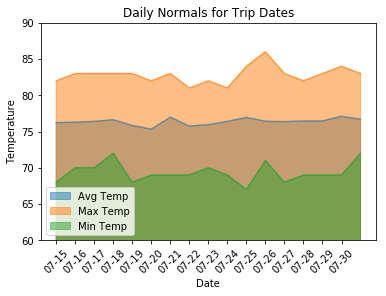

In [352]:
normals_df.plot(kind="area", stacked=False)
plt.ylim(60,90)
plt.xticks(range(16), trip_list, rotation=45)
plt.title('Daily Normals for Trip Dates')
plt.ylabel('Temperature')
plt.show()
plt.savefig('daily_normals_area_chart.png')